In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn
import os

20191216155552.record.00000-ego.csv
20191216155552.record.00001-ego.csv
20191216155552.record.00002-ego.csv
20191216155552.record.00003-ego.csv


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1576540563.933052
thresholdDistance 35.939845599320684
hesitate_time:  5.227062940597534
pedestrian walk distance:  0.3529732078473092


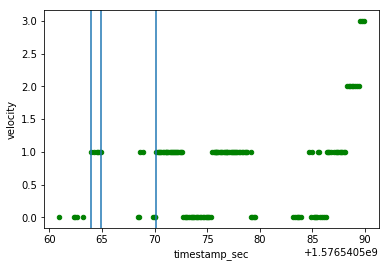

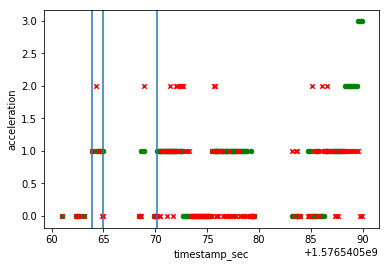

In [11]:
directory_path = "./LG_DATA/scenario_A_v2/2019-12-16-15-55-52"
ped_table_list = []
ego_table_list = []

for file in sorted(os.listdir(directory_path)):
    if("pedestrian" in file.split('-')[1]):
        path_to_file = os.path.join(directory_path, file)
        ped_table_list.append(pd.read_csv(path_to_file, sep=';'))
    else:
        print(file)
        path_to_file = os.path.join(directory_path, file)
        ego_table_list.append(pd.read_csv(path_to_file, sep=';'))


# combine different pedestrian .csvs into one dataframe
pedestrian_table = pd.concat(ped_table_list, ignore_index=True)
ego_table        = pd.concat(ego_table_list, ignore_index=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)        

# Initialize a new column for "velocity" and populate with velocity computed from velocity_x and velocity_y
# with a Euclidean metric
pedestrian_table['velocity'] = 0
pedestrian_table['velocity'].apply(pd.to_numeric)
for index, row in pedestrian_table.iterrows():
    pedestrian_table['velocity'][index] = round(math.sqrt( math.pow(pedestrian_table['velocity_x'][index],2) +  math.pow(pedestrian_table['velocity_y'][index],2) ))

# Initialize a new column for "acceleration" and populate with velocity computed from acceleration_x and acceleration_y
# with a Euclidean metric
pedestrian_table['acceleration'] = 0
pedestrian_table['acceleration'].apply(pd.to_numeric)
for index, row in pedestrian_table.iterrows():
    pedestrian_table['acceleration'][index] = round(math.sqrt( math.pow(pedestrian_table['acceleration_x'][index],2) +  math.pow(pedestrian_table['acceleration_y'][index],2) ))


# Parse Scenic Parameters
pos_stopped = []
pos_moving = []
stopped = True
moving  = False
hesitate = False
recorded = False
ped_trigger_time = -1
hesitate_start_time = -1
hesitate_stop_time = -1
ped_start_pos = [pedestrian_table.iloc[0]['position_x'], pedestrian_table.iloc[0]['position_y']]
ped_stop_pos  = []

for index, row in pedestrian_table.iterrows():
    if index <= pedestrian_table.shape[0]-3 and index > 3:
        
        # Arbitrarily take the moving avg of three consequtive indices
        vel_list = pedestrian_table['velocity'][index:index+3]
        vel = sum(vel_list)/len(vel_list)

        # Indicates that the pedestrian is stopped
        if vel >= 1:
            pos_moving.append(index)

            if stopped:
                stopped = False
                moving  = True

                if not recorded:
                    ped_trigger_time = row['timestamp_sec']
                    recorded = True

                if hesitate:
                    hesitate_stop_time = row['timestamp_sec']
                    break


        if  vel <= 0.5:
            pos_stopped.append(index)

            if moving:
                stopped = True
                moving  = False
                hesitate_start_time = row['timestamp_sec']
                ped_stop_pos = [row['position_x'], row['position_y']]
                hesitate = True

if(ped_trigger_time != -1):
    ped_trigger_index  = pedestrian_table.index[pedestrian_table['timestamp_sec'] == ped_trigger_time]
    print(ped_trigger_time)
    ped_trigger_pos_x  = pedestrian_table['position_x'][ped_trigger_index.tolist()[0]]
    ped_trigger_pos_y  = pedestrian_table['position_y'][ped_trigger_index.tolist()[0]]

    ego_trigger_index  = ego_table.index[round(ego_table['timestamp_sec'],0) == round(ped_trigger_time,0)]
    ego_trigger_pos_x  = ego_table['position_x'][ego_trigger_index.tolist()[0]]
    ego_trigger_pos_y  = ego_table['position_y'][ego_trigger_index.tolist()[0]]

    threshold_dist = math.sqrt(math.pow(ego_trigger_pos_x-ped_trigger_pos_x,2) + math.pow(ped_trigger_pos_y-ego_trigger_pos_y,2))
    hesitate_time  = hesitate_stop_time-hesitate_start_time
    ped_walkDistance = math.sqrt(math.pow(ped_start_pos[0]-ped_stop_pos[0],2) + math.pow(ped_start_pos[1]-ped_stop_pos[1],2))

    print("thresholdDistance", threshold_dist)
    print("hesitate_time: ", hesitate_time)
    print("pedestrian walk distance: ", ped_walkDistance)

    ax = pedestrian_table.plot(kind='scatter',x='timestamp_sec',y='velocity',color='green')
    plt.axvline(ped_trigger_time)
    plt.axvline(hesitate_start_time)
    plt.axvline(hesitate_stop_time)
    plt.show()
    
    ax = pedestrian_table.plot(kind='scatter',x='timestamp_sec',y='velocity',color='green')
    pedestrian_table.plot(kind='scatter',x='timestamp_sec',y='acceleration', marker = 'x' ,ax = ax ,color='red')
    plt.axvline(ped_trigger_time)
    plt.axvline(hesitate_start_time)
    plt.axvline(hesitate_stop_time)
    plt.show()
